# DS Model using LSTM

In [2]:
import context
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import src.data.data_preprocessing as util
import src.models.lstm_model as lstm

tf.compat.v1.set_random_seed(1)

### Set Hyperparameters

In [4]:
HYPER_PARAMS =  np.load('../../../models/TGDS/training_setup/hyperparameters.npy', allow_pickle=True)
HYPER_PARAMS = HYPER_PARAMS.item()

# add aditional model-spefic hyperparameters
model_hyperparameters = {
    'n_features': 1,       # number of input features    
    'num_repeat': 10,      # repetition factor for each training profile to create more auxiliary data
}

# update hyperparameters
HYPER_PARAMS.update(model_hyperparameters)

### Prepare Training/Validation/Test Data

In [5]:
TRAINING_SETS =  np.load('../../../models/TGDS/training_setup/training_sets.npy', allow_pickle=True)
TRAINING_SETS = TRAINING_SETS.item()

# select correct training set
training_sets = TRAINING_SETS['10A_all']

train_data = []
for set in training_sets:
    set_repeat = [set] * HYPER_PARAMS['num_repeat']
    train_data += set_repeat
    
train_data = np.array(train_data)

# select first profile for validation
validation_profile = [train_data[0]] 

# select arbitrary profile for testing
test_profile = np.random.choice(train_data, 1) 

# prepare input data
X_train, y_train, scalers_train = util.prepare_current_input(HYPER_PARAMS, train_data, 0, 4)
X_validation, y_validation, _ = util.prepare_current_input(HYPER_PARAMS, validation_profile, 0, 4)
X_test, y_test, _ = util.prepare_current_input(HYPER_PARAMS, test_profile, 0, 4)

Input: (93500, 100, 1)  Output/Label: (93500, 1)
Input: (1500, 100, 1)  Output/Label: (1500, 1)
Input: (1450, 100, 1)  Output/Label: (1450, 1)


### Initialize and Train Model

In [4]:
lstm = lstm.Model()
lstm.initialize(HYPER_PARAMS)

Model: "Black_Box_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
2469/2469 [==============================] - 356s 144ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0320
Epoch 2/5
2469/2469 [==============================] - 353s 143ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0312
Epoch 3/5
2469/2469 [==============================] - 351s 142ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0311
Epoch 4/5
2469/2469 [==============================] - 352s 143ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0313
Epoch 5/5
2469/2469 [==============================] - 354s 143ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0309
Training time: 1766.69s


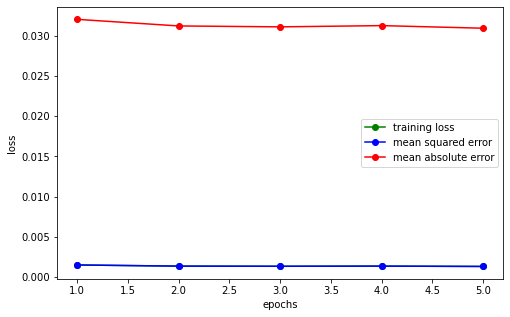

INFO:tensorflow:Assets written to: ../../../models/DS/7291\assets


In [5]:
_, fig = lstm.train(X_train, y_train, scalers_train)

# save model and hyperparameters
MODEL_ID = str(np.random.randint(10000))

lstm.model.save('../../../models/DS/' + str(MODEL_ID))
np.save('../../../models/DS/' + str(MODEL_ID) + '/hyperparameters', HYPER_PARAMS)
fig.savefig('../../../reports/figures/data_baseline-' + str(MODEL_ID) + '-learning_curve.png')

### Test Model

Validation Profile: ['Profile 10A']
Test Profile: ['Profile 10A']
2469/2469 [==============================] - 150s 61ms/step
Prediction time on Training Set:  150.05s
47/47 [==============================] - 3s 57ms/step
Prediction time on Validation Set:  2.726s
47/47 [==============================] - 3s 56ms/step
Prediction time on Test Set:  2.722s
###########################################################
            Training    Validation      Test
--------  ----------  ------------  --------
MSE (μV)    148.5         285.2     285.2
MAE (V)       0.0104        0.0158    0.0158
MaxE (V)      0.0269        0.0224    0.0224
###########################################################


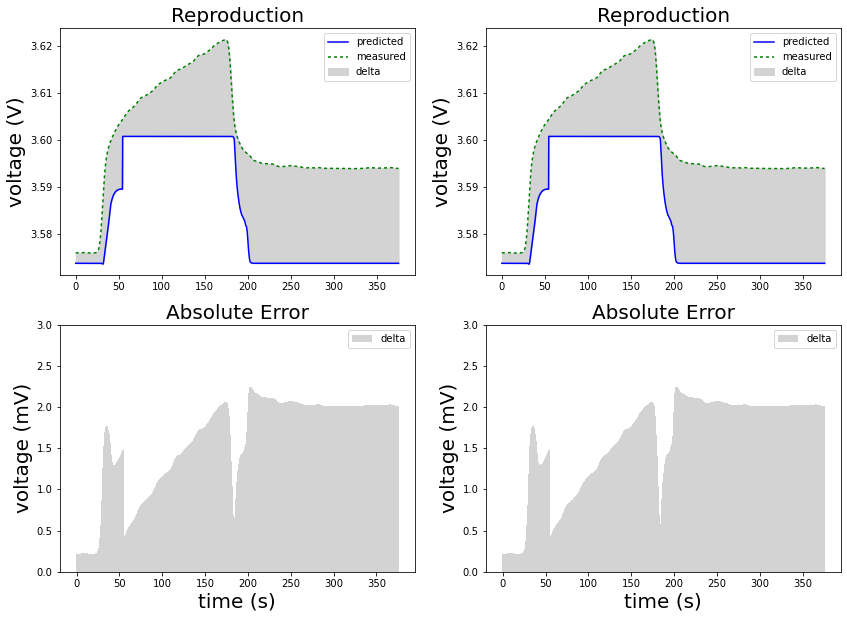

In [6]:
print('Validation Profile:', validation_profile)
print('Test Profile:', test_profile)

yhat_train_unscaled, _, _, _, _, fig = lstm.test(X_train, y_train, X_validation, y_validation, X_test, y_test, scalers_train)

# save plots and predicted sequences
np.save('../../../models/DS/' + str(MODEL_ID) + '/predictions', yhat_train_unscaled)
fig.savefig('../../../reports/figures/data_baseline-' + str(MODEL_ID) + '-validation&test_profiles.png')

### Prepare Data for Use Cases

In [6]:
TEST_SETS =  np.load('../../../models/TGDS/training_setup/test_sets.npy', allow_pickle=True)
TEST_SETS = TEST_SETS.item()

test_profiles_usecase_1 = training_sets
test_profiles_usecase_2 = TEST_SETS['Abstraction']
test_profiles_usecase_3 = TEST_SETS['Generalization']

X_case_1, y_case_1, _ = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_1, 0, 4)
X_case_2, y_case_2, _ = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_2, 0, 4)
X_case_3, y_case_3, _ = util.prepare_current_input(HYPER_PARAMS, test_profiles_usecase_3, 0, 4)

Input: (9350, 100, 1)  Output/Label: (9350, 1)
Input: (3100, 100, 1)  Output/Label: (3100, 1)
Input: (1600, 100, 1)  Output/Label: (1600, 1)


### Test Model on Use Cases

In [7]:
print('Use Case 1:', test_profiles_usecase_1)
print('Use Case 2:', test_profiles_usecase_2)
print('Use Case 3:', test_profiles_usecase_3)

lstm.test_usecases(X_train, y_train, X_case_1, y_case_1, X_case_2, y_case_2, X_case_3, y_case_3, scalers_train)

Use Case 1: ['Profile 10A', 'Profile 10A Run 040618', 'Profile 10A Run 080618', 'Profile 10A Run 070618_3', 'Profile 10A Run 070618', 'Profile 10A Run 070618_2']
Use Case 2: ['Profile 10A 3x']
Use Case 3: ['Profile -10A']


AttributeError: module 'src.models.lstm_model' has no attribute 'test_usecases'